In [622]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [623]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

def prepare_df(df):
    df = df[['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']]
    return df

df = prepare_df(df)
print(df.shape)
df.head()

(9704, 5)


,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

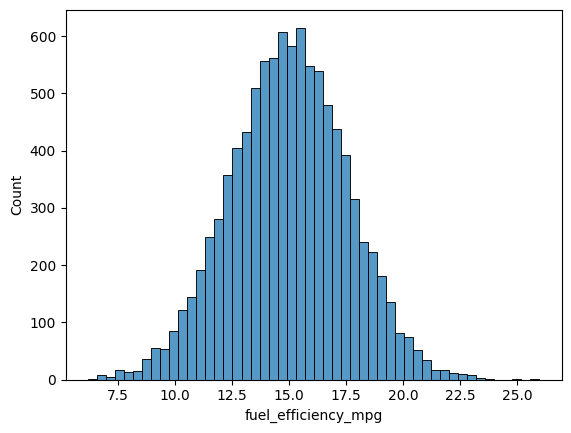

In [624]:
sns.histplot(df.fuel_efficiency_mpg, bins=50)

In [625]:
# Q1. Find column with missing values
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [626]:
# Q2. What's the median (50% percentile) for variable 'horsepower'?
df['horsepower'].median()

np.float64(149.0)

In [627]:
# Q3. Find best RMSE for filling use 0 or mean

def split(df, seed: int=42):

    n = df.shape[0]

    # 60/20/20 split
    n_val = int(n*0.2)
    n_test = int(n*0.2)
    n_train = n - n_val - n_test

    idx = np.arange(n)

    np.random.seed(seed)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    return df_train,df_val,df_test


In [628]:
df_train, df_val, df_test = split(df)

# Fill with zeros
df_zero_train, df_zero_val, df_zero_test = [df.fillna(0) for df in (df_train, df_val, df_test)]

# Fill with mean from training set
mean = df_train.mean()
df_mean_train, df_mean_val, df_mean_test = [df.fillna(mean) for df in (df_train, df_val, df_test)]


In [629]:
def train_linear_regression(df, target: str='fuel_efficiency_mpg'):
    X = df.drop(columns=[target]).values
    y = df[target].values

    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)

    # W = (Xᵀ  · X)⁻¹ · Xᵀ  · y
    w_full = XTX_inv.dot(X.T).dot(y) 
    return w_full[0], w_full[1:]

def pred(w0, w, df, target: str='fuel_efficiency_mpg'):
    X = df.drop(columns=[target]).values
    y_pred = w0 + X.dot(w)
    return y_pred

def rmse(y_actual, y_pred):
    # RMSE = √( 1/m * ∑( (g(Xᵢ) - yᵢ)²	 , i=[1,m] ) )
    se = (y_actual - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)


In [630]:
  for name, df_train, df_val in [('Zero Fill', df_zero_train, df_zero_val),
                                  ('Mean Fill', df_mean_train, df_mean_val)]:
      w0, w = train_linear_regression(df_train)
      y_val = df_val['fuel_efficiency_mpg'].values
      y_pred = pred(w0, w, df_val)
      print(f'{name}: {round(rmse(y_val, y_pred), 2)}')

Zero Fill: 0.52
Mean Fill: 0.46


In [631]:
# Question 4 - Find best R value

rs = [0, 0.01, 0.1, 1, 5, 10, 100]

def train_linear_regression_reg(df, target: str='fuel_efficiency_mpg', r: int=0.01):
    X = df.drop(columns=[target]).values
    y = df[target].values

    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_reg = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX_reg)

    # W = (Xᵀ  · X)⁻¹ · Xᵀ  · y
    w_full = XTX_inv.dot(X.T).dot(y) 
    return w_full[0], w_full[1:]


results = []
for r in rs:
    # train model
    w0, w = train_linear_regression_reg(df_zero_train, r=r)

    y_val = df_zero_val['fuel_efficiency_mpg'].values
    y_pred = pred(w0=w0,w=w,df=df_zero_val)

    error = rmse(y_val, y_pred)
    results.append((r, error))
    print(f'r={r}: {error}')

# Sort by RMSE (lowest first)
results.sort(key=lambda x: x[1])
print("\nRanked by RMSE:")
for r, error in results:
    print(f'r={r}: {error}')

r=0: 0.5173782638841655
r=0.01: 0.517111552576255
r=0.1: 0.5187525130701096
r=1: 0.5222348802092595
r=5: 0.522891609282353
r=10: 0.5229812979636556
r=100: 0.5230636233819932

Ranked by RMSE:
r=0.01: 0.517111552576255
r=0: 0.5173782638841655
r=0.1: 0.5187525130701096
r=1: 0.5222348802092595
r=5: 0.522891609282353
r=10: 0.5229812979636556
r=100: 0.5230636233819932


In [632]:
#Question 5 - See how different seeds affect rmse distribution

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [633]:
results = {}

for seed in seeds:
    df_train, df_val, df_test = split(df.fillna(0), seed)

    # train model
    w0, w = train_linear_regression(df_train)

    y_pred = pred(w0=w0,w=w,df=df_val)
    y_val = df_val['fuel_efficiency_mpg'].values

    results[seed] = rmse(y_val, y_pred)

for seed, error in results.items():
    print(f'{seed}: {error}')

std = np.std(list(results.values()))
print(f'Standard deviation: {round(std, 3)}')

0: 0.5206531296280095
1: 0.5213388912854027
2: 0.5228069974702906
3: 0.5159516741065056
4: 0.5109129460122063
5: 0.5283406459953643
6: 0.5313910658172253
7: 0.5090670387375617
8: 0.5147399129158974
9: 0.5131865908294857
Standard deviation: 0.007


In [634]:
# Question 6 - seed=9, fillna(0), r=0.001 - get rmse

df_train, df_val, df_test = split(df.fillna(0), 9)

df_combined = pd.concat([df_train, df_val])

w0, w = train_linear_regression_reg(df_combined,r=0.001)

y_pred = pred(w0=w0,w=w,df=df_test)
y_val = df_test['fuel_efficiency_mpg'].values

rmse(y_val, y_pred)

np.float64(0.5156261299166541)